## Pupillometry analysis for eye link

Analysis of pupillometry for eye link, based on the previous analysis (pupillometry_2.0) done for pupil labs data.

First step, to open and clean eye link data

## Data loading

As usual we start by importing the modules we need and loading some
`example data <eyelink-dataset>`: eye-tracking data recorded from SR research's
``'.asc'`` file format, and EEG data recorded from EGI's ``'.mff'`` file format. We'll
pass ``create_annotations=["blinks"]`` to :func:`~mne.io.read_raw_eyelink` so that
only blinks annotations are created (by default, annotations are created for blinks,
saccades, fixations, and experiment messages).



In [1]:
import mne
from mne.datasets.eyelink import data_path
from mne.preprocessing.eyetracking import read_eyelink_calibration
from pathlib import Path
import pandas as pd 
import numpy as np
from pyplr.plr import PLR
from pyplr import graphing
from pyplr import preproc
from pyplr import utils

et_fpath = Path('data') / "001_2023_07_12_11_15.asc"
df_list=[]
df_list_raw=[]
df_list_params_assets=[]
df_list_params_suprise=[]
subject='hola'

raw_et = mne.io.read_raw_eyelink(et_fpath, preload=True, create_annotations=['blinks','messages'])


Loading z:\lab\escritorio\projects\pupil_labs\analysis\pupil_labs_analysis\analysis\pupillometry\eye_link\data\001_2023_07_12_11_15.asc
Pixel coordinate data detected.Pass `scalings=dict(eyegaze=1e3)` when using plot method to make traces more legible.
Pupil-size area detected.
There are 69 recording blocks in this file. Times between  blocks will be annotated with BAD_ACQ_SKIP.


The info structure of the eye-tracking data 

In [2]:
SAMPLE_RATE=raw_et.info['sfreq']
raw_et.info

<Info | 7 non-empty values
 bads: []
 ch_names: xpos_left, ypos_left, pupil_left, xpos_right, ypos_right, ...
 chs: 4 Eye-tracking (Gaze position), 2 Eye-tracking (Pupil size)
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2023-07-12 00:20:15 UTC
 nchan: 6
 projs: []
 sfreq: 500.0 Hz
>

## Checking the calibration

EyeLink ``.asc`` files can also include calibration information.
MNE-Python can load and visualize those eye-tracking calibrations, which
is a useful first step in assessing the quality of the eye-tracking data.
:func:`~mne.preprocessing.eyetracking.read_eyelink_calibration`
will return a list of :class:`~mne.preprocessing.eyetracking.Calibration` instances,
one for each calibration. We can index that list to access a specific calibration.

In [39]:
cals = read_eyelink_calibration(et_fpath)
print(f"number of calibrations: {len(cals)}")
first_cal = cals[0]  # let's access the first (and only in this case) calibration
print(first_cal)

Reading calibration data from z:\lab\escritorio\projects\pupil_labs\analysis\pupil_labs_analysis\analysis\pupillometry\eye_link\data\001_2023_07_12_11_15.asc
number of calibrations: 2
Calibration |
  onset: -16.515 seconds
  model: HV9
  eye: left
  average error: 0.5 degrees
  max error: 1.0 degrees
  screen size: None meters
  screen distance: None meters
  screen resolution: None pixels



Calibrations have dict-like attribute access; in addition to the attributes shown in
the output above, additional attributes are ``'positions'`` (the x and y coordinates
of each calibration point), ``'gaze'`` (the x and y coordinates of the actual gaze
position to each calibration point), and ``'offsets'`` (the offset in visual degrees
between the calibration position and the actual gaze position for each calibration
point). Below is an example of how to access these data:

In [4]:
print(f"offset of the first calibration point: {first_cal['offsets'][0]}")
print(f"offset for each calibration point: {first_cal['offsets']}")
print(f"x-coordinate for each calibration point: {first_cal['positions'].T[0]}")

offset of the first calibration point: 0.52
offset for each calibration point: [0.52 0.16 0.39 0.15 0.43 0.68 0.63 0.47 1.  ]
x-coordinate for each calibration point: [ 960.  960.  960.  115. 1804.  216. 1703.  216. 1703.]


Let's plot the calibration to get a better look. Below we see the location that each
calibration point was displayed (gray dots), the positions of the actual gaze (red),
and the offsets (in visual degrees) between the calibration position and the actual
gaze position of each calibration point.


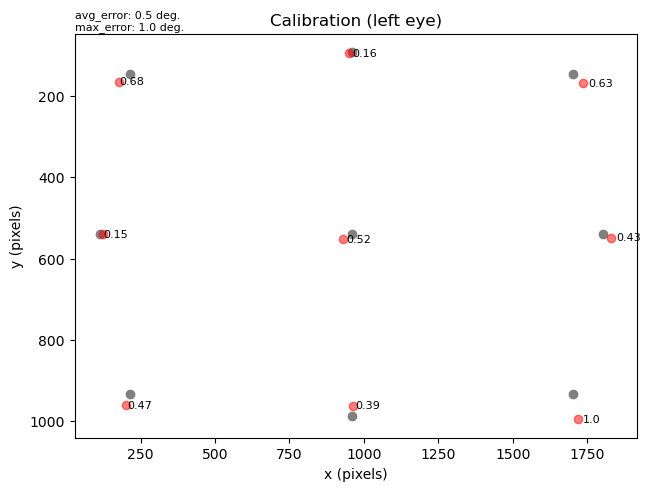

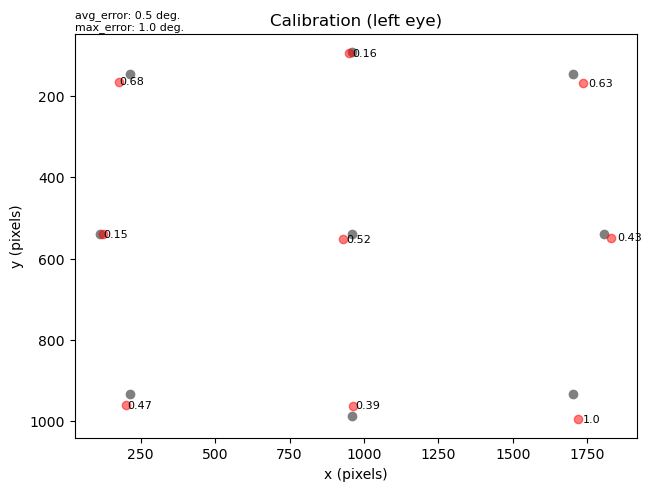

In [5]:
first_cal.plot()

## Plot the raw eye-tracking data

Let's plot the raw eye-tracking data. We'll pass a custom `dict` into
the scalings argument to make the eyegaze channel traces legible when plotting,
since this file contains pixel position data (as opposed to eye angles,
which are reported in radians).

In [6]:
raw_et.plot(scalings=dict(eyegaze=1e3))

Using qt as 2D backend.


## Handling blink artifacts

Naturally, there are blinks in our data, which occur within ``"BAD_blink"``
annotations. During blink periods, eyegaze coordinates are not reported, and pupil
size data are ``0``. We don't want these blink artifacts biasing our analysis, so we
have two options: Drop the blink periods from our data during epoching, or interpolate
the missing data during the blink periods. For this tutorial, let's interpolate the
blink samples. We'll pass ``(0.05, 0.2)`` to
:func:`~mne.preprocessing.eyetracking.interpolate_blinks`, expanding the interpolation
window 50 ms before and 200 ms after the blink, so that the noisy data surrounding
the blink is also interpolated.


In [7]:
mne.preprocessing.eyetracking.interpolate_blinks(raw_et, buffer=(0.05, 0.2))

Interpolating missing data during blinks...
Removing 'BAD_' from BAD_blink.


<RawEyelink | 001_2023_07_12_11_15.asc, 6 x 279593 (559.2 s), ~12.8 MB, data loaded>

.. important:: By default, :func:`~mne.preprocessing.eyetracking.interpolate_blinks`,
          will only interpolate blinks in pupil channels. Passing
          ``interpolate_gaze=True`` will also interpolate the blink periods of the
          eyegaze channels. Be aware, however, that eye movements can occur
          during blinks which makes the gaze data less suitable for interpolation.

In [8]:
raw_et.plot(scalings=dict(eyegaze=1e3))

## Extract common stimulus events from the data

In this experiment, a photodiode attached to the display screen was connected to both
the EEG and eye-tracking systems. The photodiode was triggered by the the light flash
stimuli, causing a signal to be sent to both systems simultaneously, signifying the
onset of the flash. The photodiode signal was recorded as a digital input channel in
the EEG and eye-tracking data. MNE loads these data as a :term:`stim channel`.

We'll extract the flash event onsets from both the EEG and eye-tracking data, as they
are necessary for aligning the data from the two recordings.

## Create the dataframe with temporal values

In [9]:
data_raw=raw_et.get_data(return_times=True)
timestamps=data_raw[1].reshape(len(data_raw[1]),1)
data_raw_values=data_raw[0].T
data_rew_time=np.append(data_raw_values,timestamps,axis=1)
col_n=raw_et.ch_names
col_n.append('time')
data_pd=pd.DataFrame(data_rew_time,
                     columns=col_n
                    )




### Create dataframe for annotations

In [10]:
raw_et.annotations.description
# raw_et.annotations.onset
annotations_pd=pd.DataFrame({'time':raw_et.annotations.onset,
                             'label': raw_et.annotations.description})

### Cut all data by annotations of interest

In [36]:
# pupil_pd_frame=final_df
import sys
from IPython.display import display
display(include=True)
sys.path.append('../../')
sys.path.append('../')
import importlib 
import commons as cm
from pyeyemo import pupillometry2_0_commons as pc 
importlib.reload(pc)


event_initial=annotations_pd['label'].values[0]
event_final=annotations_pd['label'].values[-1]

initial_anotation,_,_=cm.extract_annotations_timestamps(event_initial,'label',annotations_pd)
end_anotation=annotations_pd.iloc[-1]
display(initial_anotation)
display(end_anotation)

pupil_pd_frame=cm.filter_rows_by_temporal_values(
         dataframe=data_pd,
         time_column='time',
         ini_value=initial_anotation['time'].values[0],
         end_value=end_anotation['time']
         )

,time,label
0,0.11,Obj0150_Asset0070.tif


time          559.079
label    image_offset
Name: 585, dtype: object

In [37]:
%matplotlib qt
filter_events=annotations_pd['label'].str.contains('.tif') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')| annotations_pd['label'].str.contains('image_offset')

fig,ax=pc.plot_signal_with_events(signal_df=pupil_pd_frame,
                           annotattion_df=annotations_pd[filter_events],
                           time_col='time',
                           signal_col='pupil_left')
# ax.set_title(f'raw data for subject: {subject}')

# fig.savefig(f'figures/{subject}_Raw.png', dpi=300)

In [13]:
annotations_pd=annotations_pd[filter_events]


In [14]:
# pupil_df ['pupil_right']=2*np.sqrt(pupil_df ['pupil_right']/np.pi)


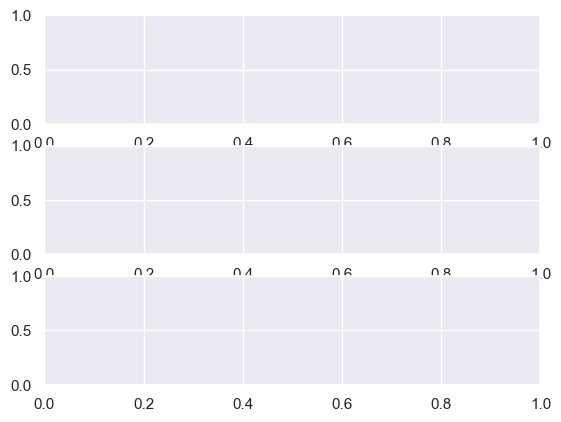

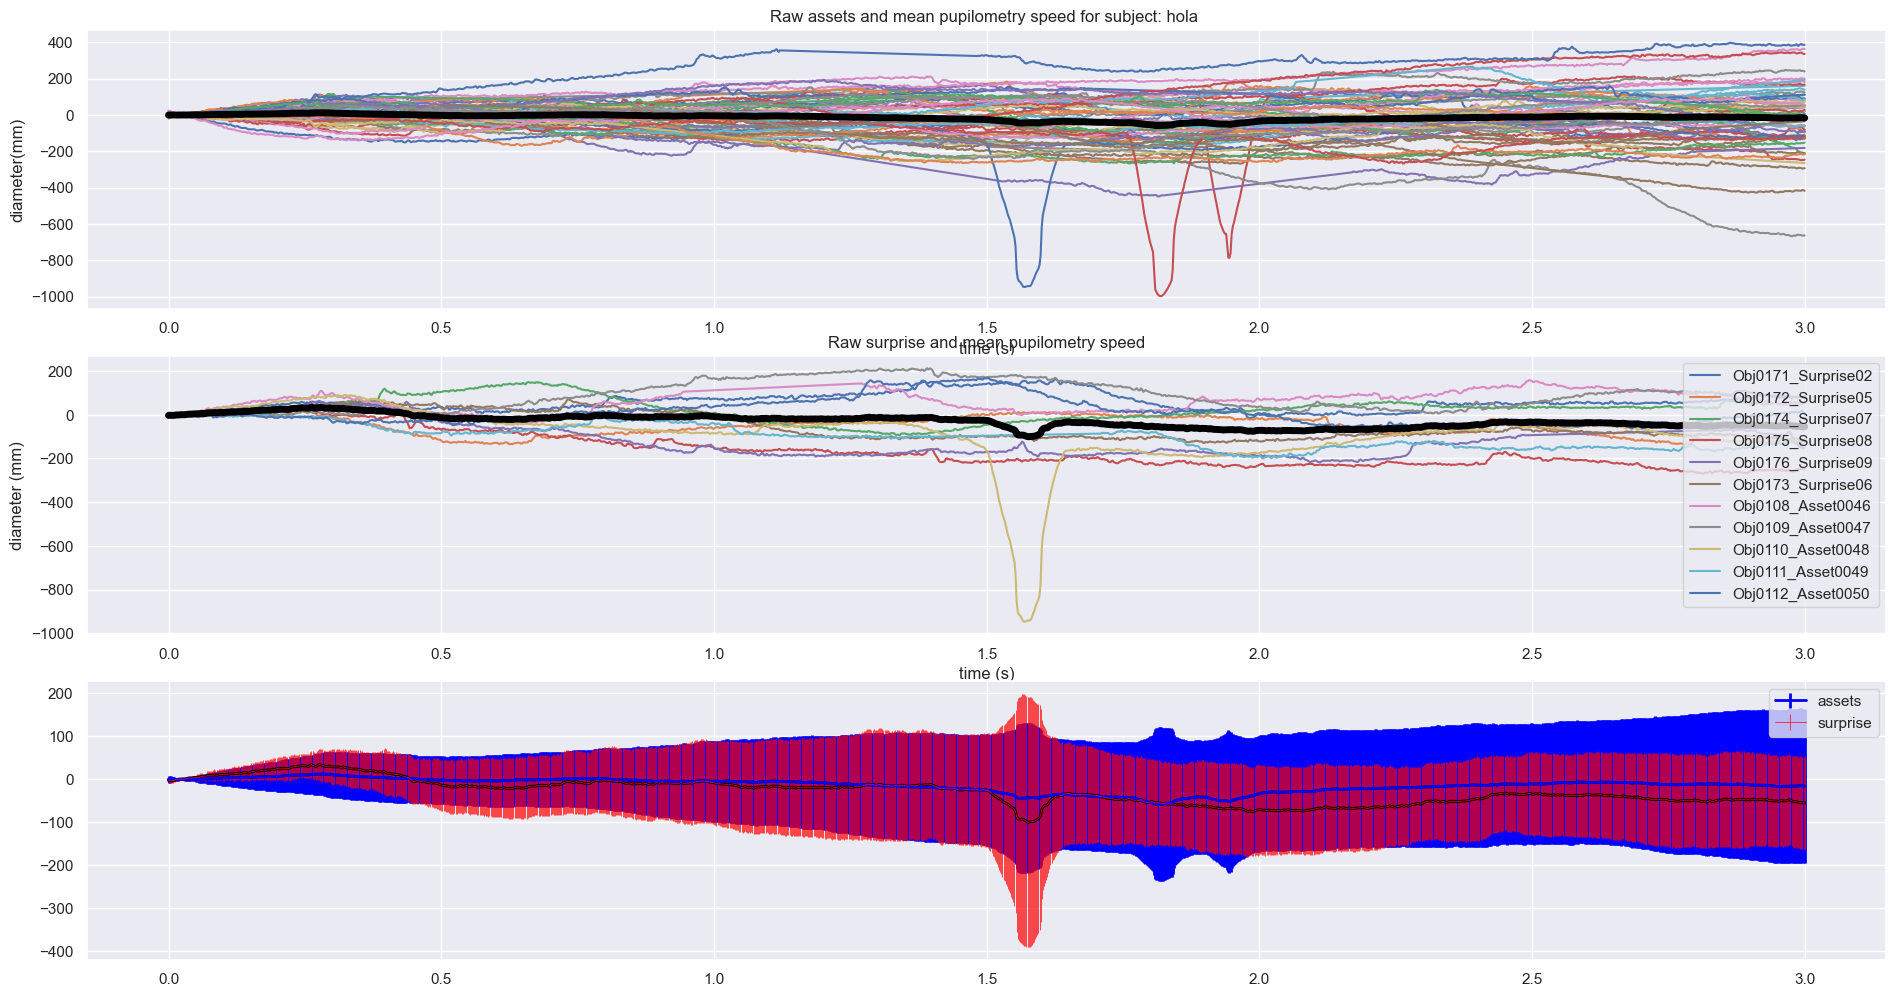

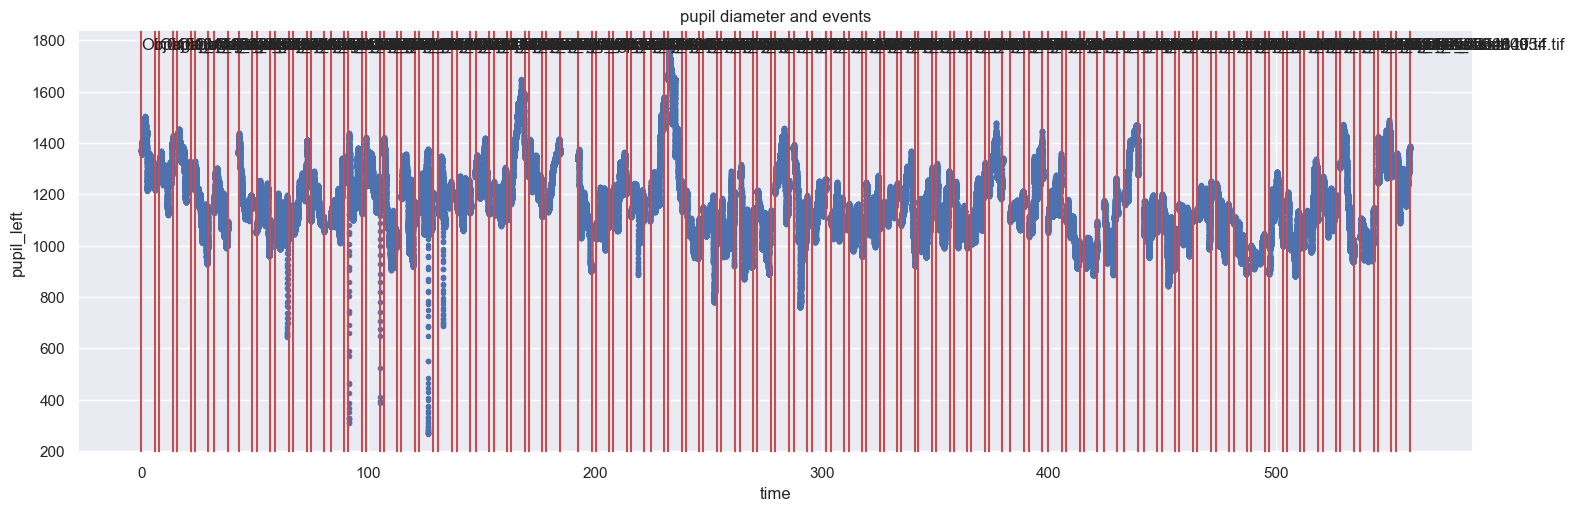

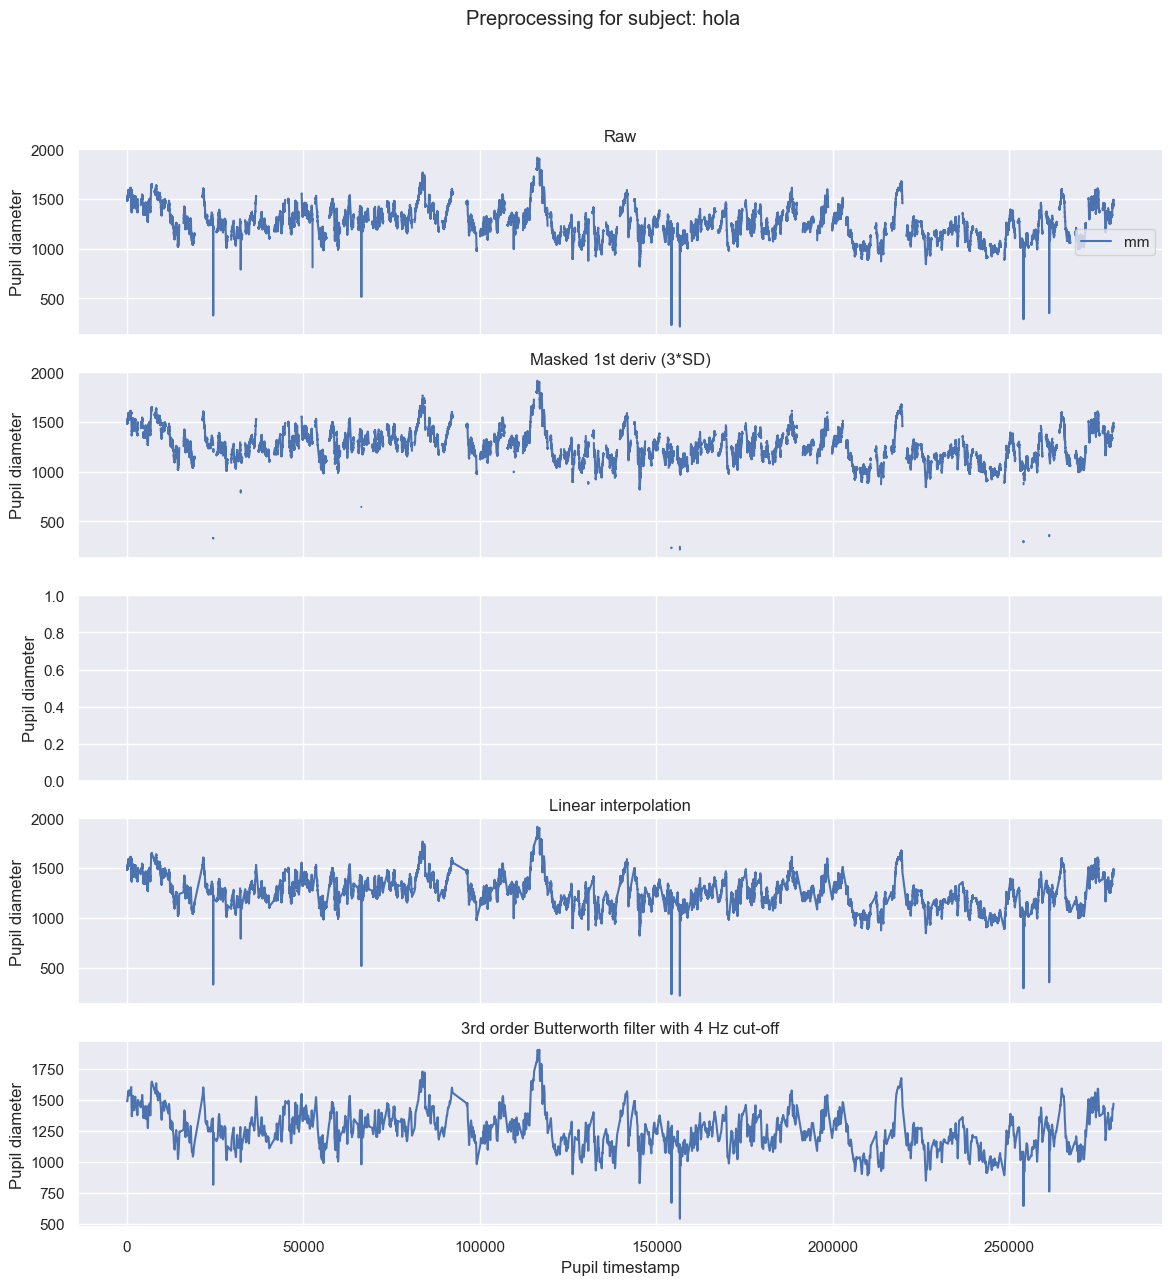

In [38]:
confidence_thr=1 #pupil condifedence for data cleaning

%matplotlib inline
# Sampling frequency
pupil_df=pupil_pd_frame

# Pupil columns to analyse
pupil_cols = ['pupil_right']

# Make figure for processing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject=subject)

# Plot the raw data
pupil_df[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
pupil_df = preproc.mask_pupil_first_derivative(
    pupil_df, threshold=3.0, mask_cols=pupil_cols)
pupil_df[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)



# Interpolate
pupil_df = preproc.interpolate_pupil(
    pupil_df, interp_cols=pupil_cols)
pupil_df[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
pupil_df = preproc.butterworth_series(
    pupil_df, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
pupil_df[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);


In [16]:
from data_curation import Normalization
nm=Normalization()
pupil_pd_frame['z_score']=nm.normalize(values=pupil_pd_frame['pupil_right'],
                                                type='z_score')

C:\Users\arturoV\AppData\Local\Temp\ipykernel_13696\2917480728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_pd_frame['z_score']=nm.normalize(values=pupil_pd_frame['pupil_right'],


### PLR analysis

In [33]:
from pyplr.plr import PLR
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

window_s=3
seconds_norm=0.05
signal_str='pupil_right'


frames_norm=np.round(seconds_norm*SAMPLE_RATE).astype(int)
win_norm=range(frames_norm)
print('Initial frames used for normalization = {} correspond to {}s'.format(frames_norm,seconds_norm))

window_frames=np.round(window_s*SAMPLE_RATE).astype(int)
print('Windows frames of interest   = {} correspond to {}s'.format(window_frames,window_s))
window=range(0,window_frames)
time_x=np.linspace(0,window_s,window_frames)

filter_events=annotations_pd['label'].str.contains('.tif') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')

# For Assets only window size data
event=annotations_pd.loc[filter_events,['label']].values.flatten()
event_strip=[image.split('.')[0] for image in event] #remove .tiiff

# event=annotations_pd['label'].values.flatten()
data_dict=dict([(key,[None]) for key in event_strip])# dict with empty keys 
data_dict_raw=dict([(key,[None]) for key in event_strip])# dict with empty keys 
data_dict_params=dict([(key,[None]) for key in event_strip])# dict with empty keys 




Initial frames used for normalization = 25 correspond to 0.05s
Windows frames of interest   = 1500 correspond to 3s


In [18]:
color_assets=['Obj0108_Asset0046','Obj0109_Asset0047',
              'Obj0110_Asset0048','Obj0111_Asset0049',
              'Obj0112_Asset0050']



In [35]:
subject='hola'
%matplotlib qt
pupil_diameter_df=pd.DataFrame()#pd.DataFrame(data_dict,index=np.arange(0,800))
for im,im_strip in zip(event,event_strip):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_pd_frame,
        time_column='time',
        ini_value=initial_anotation['time'].values[0],
        end_value=end_anotation['time']
        )

    segmented_df=segmented_df.iloc[window]
    win_blank=segmented_df.iloc[win_norm]
    asset_norm=segmented_df[signal_str]-win_blank[signal_str].mean()
    asset_raw=segmented_df[signal_str]

    data_dict[im_strip]=asset_norm.values
    data_dict_raw[im_strip]=asset_raw.values

    #Here we should add the dataframe for the extracted params
    #Tomorrow understand calculations of these params and do the statistics

#Create dataframes of interest
pupil_diameter_df=pd.DataFrame(data_dict)
pupil_diameter_df_raw=pd.DataFrame(data_dict_raw)

#To filter assets
filter_assets=list(pupil_diameter_df.columns)
filter_surprise=list(pupil_diameter_df.columns)
filter_assets=[asset for asset in filter_assets if 'Asset' in asset ]
filter_surprise=[asset for asset in filter_surprise if 'Surprise' in asset ]
[filter_surprise.append(color) for color in color_assets]

pupil_diameter_assets_df=np.mean(pupil_diameter_df.reindex(columns=filter_assets).values,axis=1)
pupil_diameter_surprise_df=np.mean(pupil_diameter_df.reindex(columns=filter_surprise).values,axis=1)
#Plot the events and suprise and save
pc.plot_events_and_surprise(signal_df=pupil_pd_frame,
                             filter_assets=filter_assets,
                             filter_surprise=filter_surprise,
                             time_x=time_x,
                             subject=subject
                            )

plr_assets = PLR(pupil_diameter_assets_df,
          sample_rate=500,
          onset_idx=1,
          stim_duration=1)

plr_surprise = PLR(pupil_diameter_surprise_df,
          sample_rate=500,
          onset_idx=1,
          stim_duration=1)

subject='hola'
pupil_diameter_df['session']=subject
pupil_diameter_df_raw['session']=subject
plr_surprise.index=[subject]
plr_assets.index=[subject]


df_list.append(pupil_diameter_df)
df_list_raw.append(pupil_diameter_df_raw)
df_list_params_suprise.append(plr_surprise)
df_list_params_assets.append(plr_assets)


ValueError: x and y must have same first dimension, but have shapes (1500,) and (279487, 58)

In [29]:
df_list.append(pupil_diameter_df)
df_concat=pd.concat(df_list)
df_concat.index.name='index1'
df_concat_group=df_concat.groupby('index1')
df_concat['session'].unique()
# df_concat.query(f"session=='ES0001_S030_PC_EM'")

array(['hola'], dtype=object)

In [30]:
window_frames=df_concat.index.max()+1#np.round(windows_s*120).astype(int)
window=range(0,window_frames)
time_x=np.linspace(0,window_s,window_frames)
%matplotlib inline
df_concat_mean=df_concat_group.mean()
df_concat_std=df_concat_group.std()

filter_assets=list(df_concat_mean.columns)
filter_surprise=list(df_concat_mean.columns)

filter_assets=[asset for asset in filter_assets if 'Asset' in asset ]
filter_surprise=[asset for asset in filter_surprise if 'Surprise' in asset ]

mat=df_concat_mean.reindex(columns=filter_assets).values
mat_std=df_concat_std.reindex(columns=filter_assets).values

mat2=df_concat_mean.reindex(columns= filter_surprise).values
mat2_std=df_concat_std.reindex(columns= filter_surprise).values

fig, ax=plt.subplots(3,1,)
ax[0].plot(time_x,mat)
ax[0].plot(time_x,np.mean(mat,axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax[0].set_title(f'Raw assets and mean pupilometry speed for subject: {subject} ')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('diameter(mm)')


ax[1].plot(time_x,mat2)
ax[1].plot(time_x,np.mean(mat2,axis=1),linewidth=5,color='black')
ax[1].set_title('Raw surprise and mean pupilometry speed')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('diameter (mm)')

ax[2].errorbar(time_x,np.mean(mat,axis=1),np.std(mat_std,axis=1),linewidth=2,color='blue')
ax[2].errorbar(time_x,np.mean(mat2,axis=1),np.std(mat2_std,axis=1),linewidth=0.5,color='red')
ax[2].legend(['assets','surprise'])
ax[2].plot(time_x,np.mean(mat2,axis=1),linewidth=2,color='black')
ax[2].plot(time_x,np.mean(mat,axis=1),linewidth=2,color='black')

fig.set_size_inches((18, 18))
fig.tight_layout()

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)


In [ ]:
initial_anotation

In [ ]:
event

In [ ]:
raw_et.crop_by_annotations(annotations=annotations_pd)
mne.Annotations